# Table of Contents
* [load data](#load-data)
* [process data](#process-data)
	* [bonuses](#bonuses)
	* [frame build](#frame-build)
	* [analysis](#analysis)
	* [building frames](#building-frames)
* [bounding box clustering](#bounding-box-clustering)
* [bonus cost estimate](#bonus-cost-estimate)
* [HTML Review](#HTML-Review)
* [hide](#hide)


In [183]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import re
import pickle
import boto
from copy import deepcopy
import json
import os
import random
import jinja2
from tqdm import tqdm
from IPython.core.display import HTML

import PIL.Image as Image
import requests

from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo

from amt_utils.mturk import pickle_this, unpickle_this

import os
import jinja2
import argparse
from jinja2 import Environment, FileSystemLoader

j2env = jinja2.Environment()

from amt_utils.bboxes import cluster_from_nms
from amt_utils.bboxes import draw_animation_seq
from amt_utils.bboxes import cluster_from_annos
from amt_utils.bboxes import create_subtask_data
from amt_utils.bboxes import draw_image_and_labels
from amt_utils.bboxes import select_labels
from amt_utils.bboxes import cluster_and_label
import warnings
warnings.filterwarnings('ignore')

In [4]:
import ai2.vision.utils as ai2vu

# load data

In [5]:
data_paths = ['./pickeled_results/turker_batch_{}.pkl'.format(i) for i in range(1,6)]

turk_data_assemble = [unpickle_this(data_path) for data_path in data_paths]

batch_2 = turk_data_assemble[0]
batch_2 = turk_data_assemble[1]
batch_3 = turk_data_assemble[2]
batch_4 = turk_data_assemble[3]
batch_5 = turk_data_assemble[4]
batch_8 = unpickle_this('./pickeled_results/turker_batch_8.pkl')

turk_data = {}
_ = [turk_data.update(data_part) for data_part in turk_data_assemble + [batch_8]]

# all_so_far = unpickle_this('./pickeled_results/turker_all_subtask_8_12.pkl')

In [6]:
len(batch_8)

1632

In [7]:
prod_batch_1_4 = unpickle_this('./pickeled_results/prod_batch_1_4.pkl')
# turk_data = {}
# _ = [turk_data.update(data_part) for data_part in [prod_batch_1_4]]
turk_data = prod_batch_1_4

In [8]:
len(turk_data)

20000

# process data

In [9]:
main_characters =  {"fred",
             "barney",
              "wilma",
              "betty",
              "pebbles",
              "bamm bamm",
              "dino",
              "mr slate",
              "baby puss",
              "hoppy",
              "empty frame",
              "no characters"}

def create_result(assmt):
    result = json.loads(assmt.answers[0][0].fields[0])
    result['h_id'] = assmt.HITId
    result['asgmt_id'] = assmt.AssignmentId
    result['worker_id'] = assmt.WorkerId
    return result


def all_main(char_set, main_chars=main_characters):
    return not bool(char_set.difference(main_chars))

In [10]:
assignments =[]
for assignment_triple in list(turk_data.values()):
    assignments.extend(assignment_triple)

assignment_results = [create_result(ar) for ar in assignments]
characters_present = [{'h_id': anno['h_id'], 'asgnmt_id': anno['asgmt_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

In [11]:
annotations_by_frame = defaultdict(list)
for anno in sorted(assignment_results, key=lambda x: x['stillID']):
    animation_id = anno['stillID'].rsplit('_', 1)[0]
    annotations_by_frame[animation_id].append(anno)

# bonuses

In [599]:
reject_variations = {
    "otherchar",
    "0ther",
    "schwenk",
}

In [600]:
def filter_rejects(chars):
    genuine_bonus = []
    reject = []
    for char in chars:
        comp_string = ''.join(c for c in char if c.isalnum()).lower()
        reject_chars = [char for var in reject_variations if var in char.replace(' ','')]
        if reject_chars or len(char.replace(' ','')) < 3:
            reject.extend(reject_chars)
        else:
            genuine_bonus.append(char)
    return reject, genuine_bonus

def assign_bonuses(assignments):
    bonuses = {}
    rejections = {}
    worker_lookup = {}
    all_descriptions = []
    for asgmt in assignments:
        aid = asgmt.AssignmentId
        worker_id = asgmt.WorkerId
        worker_lookup[aid] = worker_id
        result = create_result(asgmt)
        all_descriptions.extend([char['label'] for char in json.loads(result['characterBoxes'])])
        bonus_chars = [char['label'] for char in json.loads(result['characterBoxes']) if char['label'] not in main_characters]
        rejects, bonus_chars = filter_rejects(bonus_chars)
        if rejects:
            rejections[aid] = (rejects, bonus_chars)
        elif bonus_chars:
            bonuses[aid] = len(bonus_chars)
#             bonuses[aid] = bonus_chars
    return bonuses, rejections, worker_lookup, all_descriptions

In [603]:
worker_counts = pd.Series(list(asgmt_workers.values())).value_counts()

In [604]:
sum(worker_counts > 50)

248

In [602]:
bonuses, to_reject, asgmt_workers, all_descriptions = assign_bonuses(assignments)

In [605]:
len(assignments)

59836

In [606]:
all_rejections = []
for chars in to_reject.values():
    all_rejections.extend(chars[0])

In [607]:
all_rejections

['main characters and other characters',
 'main characters and other characters',
 'main characters and other characters',
 'main characters and other characters',
 'main characters and other characters',
 'other character',
 'main characters and other characters',
 'main charactrers and other characters',
 'other character',
 'other character',
 'main characters and other characters']

In [609]:
pd.Series(list(bonuses.values())).sum() * 0.01

151.53999999999999

In [379]:
# pickle_this(bad_aids, 'to_reject.pkl')

In [380]:
# pd.Series(all_rejections).value_counts()

In [611]:
bad_aids = set(to_reject.keys())

In [612]:
len(bad_aids)

11

In [613]:
bad_workers = set([asgmt_workers[aid] for aid in bad_aids])
len(bad_workers)

bad_workers

{'A1HL8LE2075V80', 'A1WHEV7QAX73IC'}

In [614]:
worker_bonuses = defaultdict(int)
for aid, char_count in bonuses.items():
    worker_bonuses[aid] = {
        'count': char_count,
        'worker_id': asgmt_workers[aid]
    }

In [615]:
len(worker_bonuses)

10819

In [617]:
# bonuses_payed = unpickle_this('pickeled_results/bonuses_to_pay_prod_1_4.pkl')

In [365]:
len(bonuses_payed)

2187

In [618]:
pickle_this(worker_bonuses, 'bonuses_to_pay_prod_1_4.pkl')

# analysis

## flaw finding

In [189]:
from amt_utils.flintstones import display_image

In [620]:
results_by_still = defaultdict(dict)
for anno in characters_present:
    results_by_still[anno['still_id']][anno['w_id']] = anno
results_by_still = dict(results_by_still)

In [621]:
len(results_by_still)

20000

In [1115]:
missing_turker_stills = []

worker_flaws = {
    'self_inconsistent_empty_frame' : [],
    'disagree_on_empty': [],
    'disagree_on_number': []
}


for still, still_annos in list(results_by_still.items()):
    char_sets = {w_anno['w_id']: w_anno['characters'] for w_anno in still_annos.values()}
    if len(char_sets) < 3:
        missing_turker_stills.append(still)
        continue
    char_set_lengths = {w_anno['w_id']: len(w_anno['characters']) for w_anno in still_annos.values()}
    mode_chars = st.mode(list(char_set_lengths.values()))
    mode_count = mode_chars.count[0]
    mode_set = mode_chars.mode[0]
    if mode_count == 2:
        try:
            dis_wid = [dis_wid for dis_wid, count in char_set_lengths.items() if count != mode_set][0]
            worker_flaws['disagree_on_number'].append({dis_wid: still})
        except IndexError:
            print(still)
    all_chars = set()
    _ = [all_chars.update(char_set) for char_set in char_sets.values()]
    for wid, char_set in char_sets.items():
        if 'empty frame' in char_set:
            if len(char_set) > 1:
                worker_flaws['self_inconsistent_empty_frame'].append({wid: still})
            elif len({owid:chars for owid, chars in char_sets.items() if (owid != wid and chars.difference({'empty frame'}))}) > 1:
                worker_flaws['disagree_on_empty'].append({wid: still})
    if all_chars.difference(set(main_characters)):
        continue
   

In [1116]:
len(missing_turker_stills)

163

In [1118]:
worker_flaws['disagree_on_number']

[{'A26ERTJPV1A1IM': 's_05_e_22_shot_016214_016288_40.png'},
 {'A3UPV16IECELHV': 's_02_e_17_shot_000755_000829_40.png'},
 {'A28URN0B675OIE': 's_06_e_22_shot_016698_016772_40.png'},
 {'A3UPV16IECELHV': 's_01_e_14_shot_031636_031710_40.png'},
 {'A1KUCRDRXEUGW3': 's_04_e_20_shot_028325_028399_40.png'},
 {'AO23DKI6107TH': 's_06_e_21_shot_018280_018354_40.png'},
 {'A3HDMR3ZFQVT7B': 's_02_e_30_shot_021948_022022_40.png'},
 {'A1KJR0VT46ZV5I': 's_02_e_20_shot_013783_013857_40.png'},
 {'A9ALF1SODWQE5': 's_04_e_03_shot_002717_002791_40.png'},
 {'A3HDMR3ZFQVT7B': 's_04_e_01_shot_028343_028417_40.png'},
 {'A3UPV16IECELHV': 's_06_e_10_shot_026827_026901_40.png'},
 {'A2J0W73DZ7I4RR': 's_06_e_21_shot_010998_011072_40.png'},
 {'A3UPV16IECELHV': 's_04_e_12_shot_024627_024701_40.png'},
 {'A2CXEAMWU2SFV3': 's_01_e_02_shot_015550_015624_40.png'},
 {'A28WKEUHQLFVS3': 's_01_e_13_shot_022770_022844_40.png'},
 {'A3UPV16IECELHV': 's_02_e_27_shot_037433_037507_40.png'},
 {'A3I8WDKEEUWM81': 's_04_e_17_shot_009271

In [1097]:
# test_stills = {'test': results_by_still[still_to_inspect]}

In [1145]:
char_number_disagree = pd.Series([list(wrk.keys())[0] for wrk in worker_flaws['disagree_on_number']]).value_counts()
char_number_disagree = char_number_disagree[char_number_disagree > 100]

In [1146]:
incons_empty_frames = pd.Series([list(wrk.keys())[0] for wrk in worker_flaws['self_inconsistent_empty_frame']]).value_counts()

In [1147]:
disagree_empty_frame = pd.Series([list(wrk.keys())[0] for wrk in worker_flaws['disagree_on_empty']]).value_counts()

In [1148]:
two_flawed_workers = set(incons_empty_frames.index).intersection(set(disagree_empty_frame.index))

In [1149]:
len(two_flawed_workers)

28

In [1155]:
prolific_workers = all_chars_agged[all_chars_agged > 200]
suspect_workers = set(prolific_workers.index).intersection(char_number_disagree.index).difference(to_reject_empty).difference(to_reject_all)
sw_list = list(suspect_workers)

In [1156]:
len(suspect_workers)

6

In [1323]:
most_prolific = set(prolific_workers.sort_values(ascending=False)[:5].index)

In [1322]:
prolific_workers.sort_values(ascending=False)[:10]

w_id
A3UPV16IECELHV    5490
A3HDMR3ZFQVT7B    4496
A1CF1W8CP0DHB0    2156
A1RULXRXR2XF6M    1683
A2X7BE2FSPUKCK    1606
A2CXEAMWU2SFV3    1383
A1QP6651C4Q8NS    1371
A2R65L9397776L    1315
A3R6KO03P9QLNO    1069
A3D61CCA0LVMWV     997
Name: characters, dtype: int64

In [1324]:
most_prolific.intersection(to_reject_all)

{'A1CF1W8CP0DHB0', 'A2X7BE2FSPUKCK'}

In [1197]:
to_reject_empty = {'A15DOG6AXQ7LGY', 'A3R6KO03P9QLNO', 'A1IOMFFEKCWOIT', 'A1RULXRXR2XF6M', 'A2L97S8Z5FZK5N', 'A3UPV16IECELHV', 'A2NJTYYY37DNO', 'A3UPV16IECELHV', 'A3HDMR3ZFQVT7B'}

In [1299]:
to_reject_all = {'A273GB71FE8RIV', 'A2CXEAMWU2SFV3', 'A13ISH3PAGHO0A', 'A1QP6651C4Q8NS', 'A1QP6651C4Q8NS', 'A9ALF1SODWQE5', 'A2X7BE2FSPUKCK', 'A2PU4YNWITAQVL', 'A1CF1W8CP0DHB0'}

In [1325]:
worker_ln = 5
suspect_worker_df = char_df[char_df['w_id'] == 'A1CF1W8CP0DHB0']
sw_list[worker_ln]

'A1CF1W8CP0DHB0'

['barney']


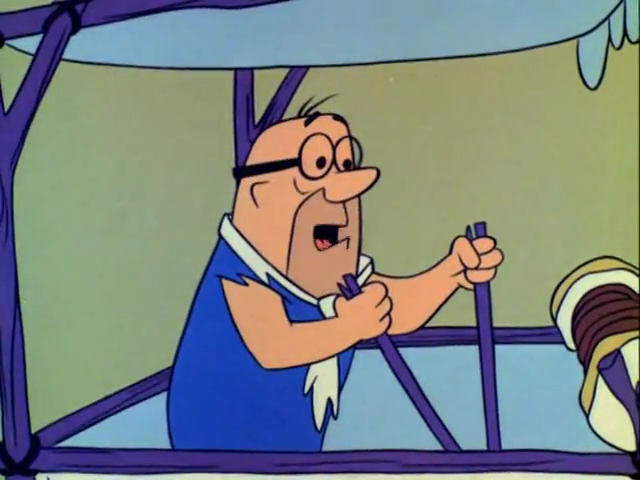

In [1339]:
rown = random.randint(0, suspect_worker_df.shape[0])
still_to_inspect = suspect_worker_df.iloc[rown]['still_id']
print(suspect_worker_df.iloc[rown]['characters'])
display_image(still_to_inspect)

In [1302]:
all_empty_suspect_df = char_df[char_df['w_id'].isin(to_reject_empty)]
all_total_suspect_df = char_df[char_df['w_id'].isin(to_reject_all)]

In [1314]:
len(all_total_suspect_df)

7420

In [1303]:
all_empty_suspect_df_e_only = all_empty_suspect_df[all_empty_suspect_df['characters'].apply(lambda x: 'empty frame' in x)]

In [1313]:
len(all_empty_suspect_df_e_only)

2034

In [1304]:
assignemnts_to_reject = set(all_empty_suspect_df_e_only['asgnmt_id'].tolist()).union(set(all_total_suspect_df['asgnmt_id'].tolist()))

In [1307]:
len(assignemnts_to_reject)

9454

In [1308]:
to_reject_empty

{'A15DOG6AXQ7LGY',
 'A1IOMFFEKCWOIT',
 'A1RULXRXR2XF6M',
 'A2L97S8Z5FZK5N',
 'A2NJTYYY37DNO',
 'A3R6KO03P9QLNO',
 'A3UPV16IECELHV'}

In [1340]:
pickle_this(to_reject_empty.union(to_reject_all), 'workers_to_ban_prod_1_4.pkl')

In [1341]:
pickle_this(assignemnts_to_reject, 'assignments_to_reject_prod_1_4.pkl')

## pd

In [63]:
def make_standard_fig(fig_plt, fig_labels=None, outfile='latest_fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=35, verticalalignment='bottom', color=label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=35, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=30, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=28)
    plt.tick_params(axis='y', which='major', labelsize=23)
#     plt.savefig(outfile, bbox_inches='tight')

In [64]:
char_df = pd.DataFrame(characters_present)
char_df['aid'] = char_df['still_id'].apply(lambda x: x.rsplit('_', 1)[0])
char_df['all_main'] = char_df['characters'].apply(lambda x: all_main(x))
char_df['n_chars'] = char_df['characters'].apply(lambda x: len(x))
all_chars = [c for char_list in char_df['characters'].apply(lambda x: list(x)).tolist() for c in char_list]

In [65]:
char_ser = pd.Series(all_chars)

In [66]:
char_counts = char_ser.value_counts()

In [67]:
fig_labels = {
    'fig_title': 'Character Frequency', 
    'x_label': 'Character',
    'y_label': '# Occurrences'
}

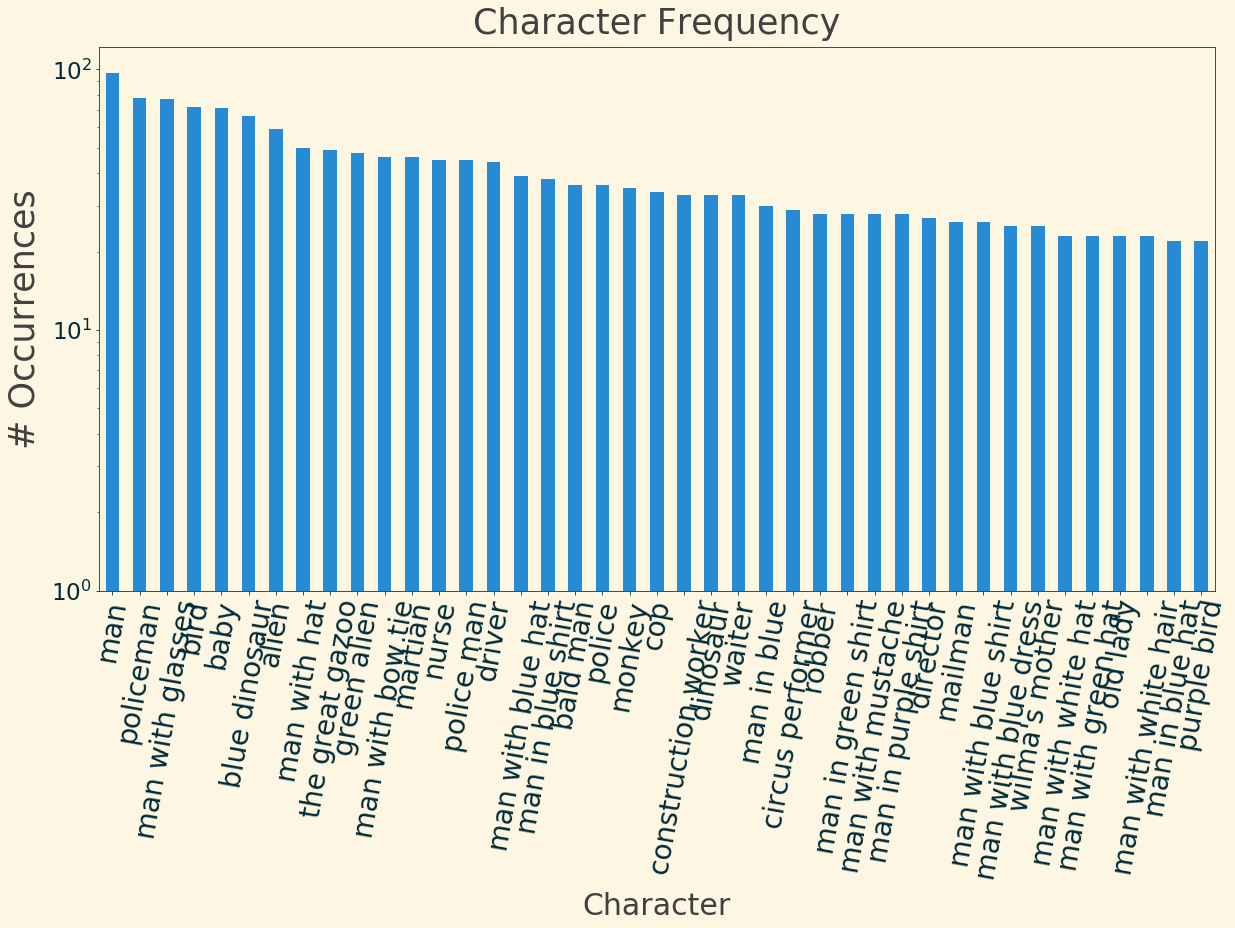

In [68]:
char_hist = char_counts[(char_counts > 20) &  (char_counts < 100)].plot(kind="bar", log=True)
plt.xticks(rotation=80) 
make_standard_fig(char_hist, fig_labels)

In [69]:
# sample_row = char_df[char_df['w_id'] == 'A3R6KO03P9QLNO']
# sample_row =  sample_row[sample_row['characters'].apply(lambda x: bool(x.intersection({'empty frame'})))].iloc[random.randint(0, 100)]
# print(sample_row['characters'])
# display_image(sample_row['still_id'])

In [70]:
grouped_by_still = char_df.groupby('still_id')
agg_df = grouped_by_still.aggregate(len)

agged_on_mode = grouped_by_still.agg(lambda x: st.mode(x))

In [71]:
consensus_results_df = agged_on_mode.reset_index()

consensus_results_df['count_mode'] = consensus_results_df['n_chars'].apply(lambda x: x[1][0])
consensus_results_df['mode_count'] = consensus_results_df['characters'].apply(lambda x: x[1][0])

consensus_results_df['all_agree'] = consensus_results_df['count_mode'] == 3
consensus_results_df['two_agree'] = consensus_results_df['count_mode'] == 2

char_count_df = consensus_results_df[consensus_results_df['count_mode'] == 3]

agree_all_main = consensus_results_df['all_main'].apply(lambda x: x[1][0]) == 3 

not_main =set(consensus_results_df[~agree_all_main]['still_id'].tolist())
not_main_df = char_df[char_df['still_id'].isin(not_main)]


all_agree = consensus_results_df[agree_all_main][consensus_results_df[agree_all_main]['all_agree']]
disagree = consensus_results_df[agree_all_main][~consensus_results_df[agree_all_main]['all_agree']]

all_agree_set = set(all_agree['still_id'].tolist())

count_all_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 3]['still_id'].tolist())
count_two_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 2]['still_id'].tolist())
count_none_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 1]['still_id'].tolist())

conflict_images = set(disagree['still_id'].tolist())

conflict_df = char_df[char_df['still_id'].isin(conflict_images)]

In [76]:
consensus_count_df = consensus_results_df[consensus_results_df['count_mode'] > 1]


In [81]:
consensus_count_df['frame_char_count'] = consensus_count_df['n_chars'].apply(lambda x: x[0][0])

In [90]:
fig_labels = {
    'fig_title': '# Characters in Frame', 
    'x_label': '# Characters',
    'y_label': '# Frames'
}

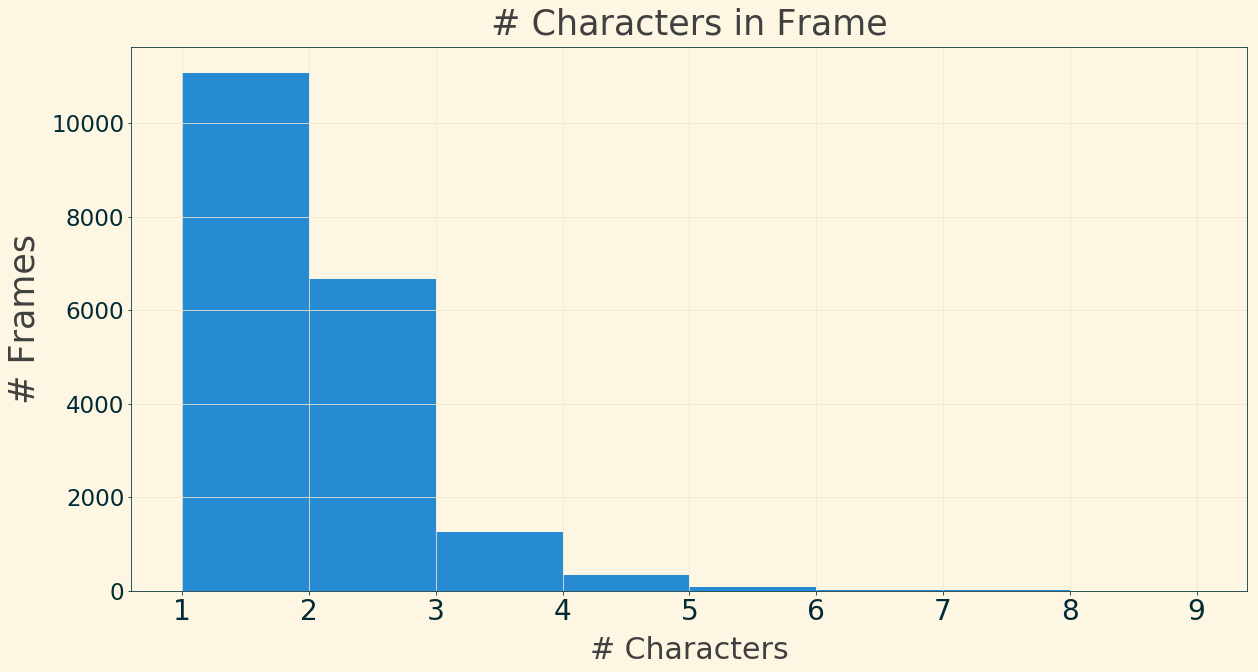

In [103]:
_ = consensus_count_df[consensus_count_df['frame_char_count'] < 11]['frame_char_count'].hist(bins=8)
# plt.xticks(rotation=80) 
make_standard_fig(char_hist, fig_labels)

In [644]:
char_df['characters'] = char_df['characters'].apply(lambda x: list(x))
grouped_by_worker = char_df.groupby('w_id')

In [645]:
w_agged = grouped_by_worker['characters'].sum()

del_hit = 'A1D9FOXZ0UT0L2'

w_agged = w_agged[~w_agged.index.str.contains(del_hit)]

# unique_chars = w_agged.apply(lambda x: len(x) /len(set(x)))

empty_fraction = w_agged.apply(lambda x: len([char for char in x if char == 'empty frame'])/ len(x))

empty_workers = empty_fraction[empty_fraction.sort_values(ascending=False) > 0.2]

In [646]:
empty_workers.index.intersection(set(prolific_workers.index))

Index([], dtype='object')

In [647]:
all_chars_agged = w_agged.apply(lambda x: len(x))

In [648]:
prolific_workers = all_chars_agged[all_chars_agged > 100]

suspect_workers = set(prolific_workers.index).intersection(set(empty_workers.index))

## empty_workers

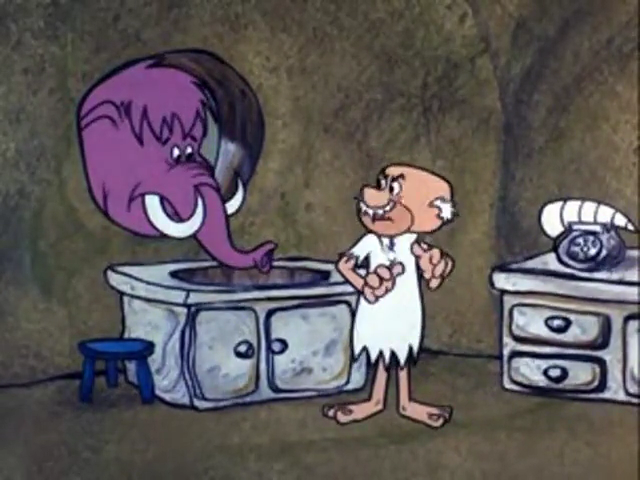

In [487]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

image_url = s3_base_path + 's_04_e_05_shot_015403_015477_40.png'
Image.open(requests.get(image_url, stream=True).raw)

In [799]:
char_df['characters'].apply(lambda x: [c for c in x if c != 'empty frame']).apply(lambda x: len(x)).mean()

1.4475733672036901

In [800]:
1632 * (1 + 1.38)

3884.16

In [305]:
# char_df[char_df['w_id'].isin(suspect_workers)][400:]

In [801]:
mono_worker = unique_chars[unique_chars < 5]

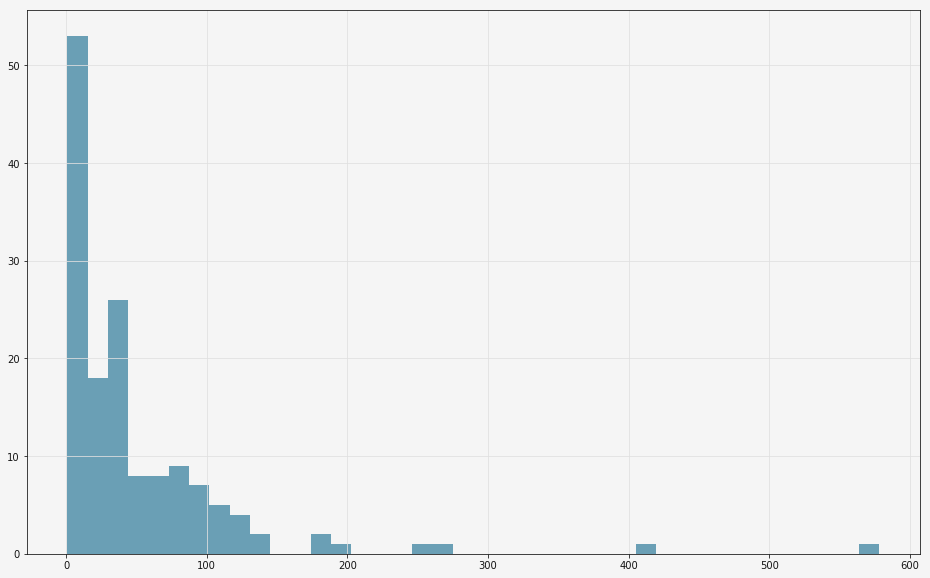

In [211]:
_ = all_chars.hist(bins=40)

In [154]:
consensus_results_df[consensus_results_df['two_agree']]

,still_id,characters,h_id,w_id,aid,all_main,n_chars,count_mode,mode_count,all_agree,two_agree
34,s_01_e_06_shot_021230_021304_40.png,"([{man with scarf and cap, man with blue glass...","([3NQUW096N78TADH124PJ0SFMXC29LH], [3])","([A1CUIN1FSZCM50], [1])","([s_01_e_06_shot_021230_021304], [3])","([False], [2])","([2], [2])",2,1,False,True
35,s_01_e_06_shot_023265_023339_40.png,"([{fred}], [1])","([3D17ECOUOFVU54OHSL6QP03MZEM31N], [3])","([A11NUW5OVADGYU], [1])","([s_01_e_06_shot_023265_023339], [3])","([False], [2])","([2], [2])",2,1,False,True
41,s_01_e_07_shot_007742_007816_40.png,"([{barney}], [1])","([307L9TDWJZSXJBV6X84OM7GP2FS3NW], [3])","([A1J8Y204VZNWQW], [1])","([s_01_e_07_shot_007742_007816], [3])","([False], [2])","([1], [2])",2,1,False,True
52,s_01_e_13_shot_014034_014108_40.png,"([{fred}], [1])","([3MGHRFQY2MPVEI0NLNVG1PGP3NBY0L], [3])","([A11NUW5OVADGYU], [1])","([s_01_e_13_shot_014034_014108], [3])","([True], [3])","([1], [2])",2,1,False,True
55,s_01_e_13_shot_028290_028364_40.png,"([{betty, wilma}], [1])","([37NXA7GVSU6R7KU455UFSA4JO4KVLI], [3])","([A26699AEVYMM7N], [1])","([s_01_e_13_shot_028290_028364], [3])","([False], [2])","([3], [2])",2,1,False,True
60,s_01_e_14_shot_014144_014218_40.png,"([{fred, wilma}], [2])","([3CMV9YRYP41IGPUAOGGWPMTPTHCJLK], [3])","([A1OFOVU6TCQ2K3], [1])","([s_01_e_14_shot_014144_014218], [3])","([True], [3])","([2], [2])",2,2,False,True
62,s_01_e_14_shot_024354_024428_40.png,"([{fred}], [1])","([32CAVSKPCFPE4Y10752RC9TMCR5U1L], [2])","([A2QG1N2LFV0VXW], [1])","([s_01_e_14_shot_024354_024428], [2])","([True], [2])","([1], [2])",2,1,False,True
65,s_01_e_16_shot_006532_006606_40.png,"([{wilma}], [2])","([3MQY1YVHS4K6XKAQQILAC2B3FCD2BU], [3])","([A1CXAIALV3056P], [1])","([s_01_e_16_shot_006532_006606], [3])","([True], [2])","([1], [2])",2,2,False,True
66,s_01_e_16_shot_013486_013560_40.png,"([{fred, barney}], [2])","([3XBYQ44Z6Q4S5M2E4O1203XEPQ8TWT], [3])","([A1CXAIALV3056P], [1])","([s_01_e_16_shot_013486_013560], [3])","([True], [3])","([2], [2])",2,2,False,True
70,s_01_e_16_shot_025041_025115_40.png,"([{fred, barney}], [2])","([3RWO3EJELI91CTT4QJ3X236N4AE1PX], [2])","([A1HA4T6P2CM2WV], [1])","([s_01_e_16_shot_025041_025115], [2])","([True], [2])","([2], [2])",2,2,False,True


In [138]:
600 * 3 * 3

5400

In [139]:
char_df.shape[0] * 0.05

243.4

In [816]:
char_counts = pd.Series(all_chars).value_counts()

In [821]:
char_counts[char_counts < 35].sum()

13206

In [142]:
char_counts[char_counts < 16].sum()

932

In [143]:
char_df['empty'] = ~char_df['characters'].apply(lambda x:bool(x.difference(set(empty_characters))))

In [144]:
char_df['nonmain_characters'] = char_df['characters'].apply(lambda x: len(x.difference(set(main_characters))))

In [145]:
grouped_by_aid = char_df.groupby('aid')

In [146]:
grouped_by_aid.agg(max)['nonmain_characters'].sum()

708

In [147]:
grouped_by_aid.agg(max).shape

(1632, 8)

In [148]:
grouped_by_aid.agg(max)['nonmain_characters'].sum() * 3 * 3  * 0.02

127.44

In [150]:
# grouped_by_aid.agg(max)[grouped_by_aid.agg(min)['empty'] == True]

In [151]:
grouped_by_aid.agg(min)['empty'].sum()

73

In [152]:
grouped_by_aid.agg(max).shape

(1632, 8)

# create subtask data

In [10]:
from amt_utils.bboxes import create_subtask_data
from amt_utils.bboxes import cluster_from_nms

In [12]:
# pickle_this(annotations_by_frame, 'batch_1_4_annotations_by_frame')

In [36]:
len(annotations_by_frame)

20000

In [24]:
st_stills = unpickle_this('subtask_still.pkl')

In [48]:
st_still_1 = {k:v for k,v in st_stills.items() if v > 0}

In [50]:
pickle_this(st_still_1, 'prod_1_4_subtask.pkl')

In [49]:
len(st_still_1)

18154

In [45]:
quality_filtered_subtasks[0]

's_01_e_01_shot_000099_000173'

In [34]:
test_sub_anno = list(annotations_by_frame.items())[:3]

In [18]:
gen_subtask(*list(annotations_by_frame.items())[0])

's_01_e_01_shot_000099_000173'

In [23]:
def gen_subtask(aid, animation_annos):
    return aid

In [192]:
processed_stage_1_a = {}
for aid, animation_annos in tqdm(list(annotations_by_frame.items())):
    try:
        consensus_boxes, labels = cluster_and_label(animation_annos, cluster_from_nms)
        label_choices = select_labels(consensus_boxes, labels)
        processed_stage_1_a[aid] = consensus_boxes
    except:
        print(aid)

 19%|█▉        | 3752/20000 [00:02<00:07, 2111.39it/s]

s_02_e_04_shot_023193_023267


100%|██████████| 20000/20000 [00:11<00:00, 1778.79it/s]


In [196]:
pickle_this(processed_stage_1_a, 'processed_stage1_boxes.pkl')

In [194]:
len(processed_stage_1_a)

19999

In [19]:
subtask_stills = {}
for aid, animation_annos in tqdm(list(annotations_by_frame.items())):
    try:
        two_frame_img, char_crops = create_subtask_data(animation_annos, cluster_from_nms)
        if char_crops:
#             two_frame_img.save('./subtask_data/frames/' + aid + '_taskb.png')
            n_chars = len([charn for charn, char_image in enumerate(char_crops)])
            subtask_stills[aid + '_taskb.png'] = n_chars
    except:
        print(aid)

100%|██████████| 1632/1632 [01:27<00:00, 18.64it/s]


In [23]:
pickle_this(subtask_stills, 'subtask_stills_8.pkl')

In [197]:
list(subtask_stills.values())[0]

NameError: name 'subtask_stills' is not defined

In [20]:
# subtask_stills = {}
# for aid, animation_annos in tqdm(list(annotations_by_frame.items())):
#     try:
#         two_frame_img, char_crops = create_subtask_data(animation_annos, cluster_from_nms)
#         if char_crops:
#             two_frame_img.save('./subtask_data/frames/' + aid + '_taskb.png')
#             n_chars = len([char_image.save('./subtask_data/char_crops/' + aid + '_char_' + str(charn) +'_taskb.png') for charn, char_image in enumerate(char_crops)])
#             subtask_stills[aid + '_taskb.png'] = n_chars
#     except:
#         print(aid)

In [20]:
# pickle_this(subtask_stills, 'subtask_stills_to_anno_prod_1_4.pkl')

In [202]:
st_rev = unpickle_this('./pickeled_results/prod_1_4_subtask.pkl')

FileNotFoundError: [Errno 2] No such file or directory: './pickeled_results/s_02_e_07_shot_010402_010476.pkl'

In [207]:
st_rev['s_02_e_07_shot_010402_010476_taskb.png']

4

# bounding box clustering

In [12]:
len(annotations_by_frame)

20000

In [13]:
rev_dir = 'review_results'
img_dir = 'review_frames'

review_seq = {}
error_frames = []
# for aid, animation_annos in tqdm(random.sample(list(annotations_by_frame.items()), 200)):
for aid, animation_annos in tqdm(list(annotations_by_frame.items())):
    single_frame_image, consensus_boxes, labels = draw_image_and_labels(animation_annos, cluster_from_nms)
    img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
#     single_frame_image.save(img_path)
    label_choices = select_labels(consensus_boxes, labels)
    avg_votes = np.mean([box['votes'] for box in consensus_boxes])
    avg_votes = np.nan_to_num(avg_votes)
    possible_labels = [c['possible_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
    chosen_labels = [c['chosen_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
    review_seq[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}

#     except:
#         error_frames.append(aid)

# rev_page = generate_review_page(review_seq, 'bbox_review_new_8_14_small.html')

100%|██████████| 20000/20000 [03:28<00:00, 95.82it/s] 


In [39]:
list(review_seq.items())[0]

('s_01_e_01_shot_000099_000173',
 {'chosen_labels': ['fred', 'barney'],
  'possible_labels': [{'fred'}, {'barney'}],
  'votes': 3.0})

In [44]:
quality_filtered_subtasks = [aid for aid, labels in review_seq.items() if len(labels['chosen_labels']) > 0]
quality_filtered_subtasks = [aid for aid, labels in review_seq.items() if labels['votes'] > 1]

In [107]:
filtered_out_single_vote = [aid for aid, labels in review_seq.items() if labels['votes'] < 1]

In [136]:
review_single

{'s_06_e_25_shot_033847_033921': {'chosen_labels': [],
  'possible_labels': [],
  'votes': 0.0}}

In [16]:
consensus_char_labels = [anim['chosen_labels'] for anim in review_seq.values()]
consensus_labels = [item for sublist in consensus_char_labels for item in sublist]

In [17]:
len(consensus_labels)

29097

In [46]:
char_ser = pd.Series(consensus_labels).value_counts()

In [60]:
fig_labels = {
    'fig_title': 'Minor Character Frequencies-log axis', 
    'x_label': '# Occurrences',
    'y_label': '# Characters'
}

# _  = char_ser[char_ser < 81].hist(bins=80, log=True)
# make_standard_fig(char_hist, fig_labels)

In [18]:
con_labels_counts = pd.Series(consensus_labels).value_counts()

In [153]:
fig_labels = {
    'fig_title': 'Consensus Character Frequency- Somewhat Frequent', 
    'x_label': 'Character',
    'y_label': '# Occurrences'
}

# char_hist = con_labels_counts[(con_labels_counts > 3) &  (con_labels_counts < 10)].plot(kind="bar", log=False)
# # char_hist = con_labels_counts.plot(kind="bar")
# plt.xticks(rotation=70) 
# make_standard_fig(char_hist, fig_labels)

wilma wilma
wilma wilma
----------
Selected Boxes
----------
{'box': array([218,  63, 503, 470]), 'area': 115995, 'label': 'wilma', 'idx': 2, 'votes': 3}
----------
Duplicate Boxes
----------
{'box': array([209,  62, 508, 480]), 'area': 124982, 'label': 'wilma', 'idx': 1, 'duplicate_of': 2}
{'box': array([269, 103, 399, 243]), 'area': 18200, 'label': 'wilma', 'idx': 0, 'duplicate_of': 2}
[['wilma'], ['wilma'], ['wilma']]


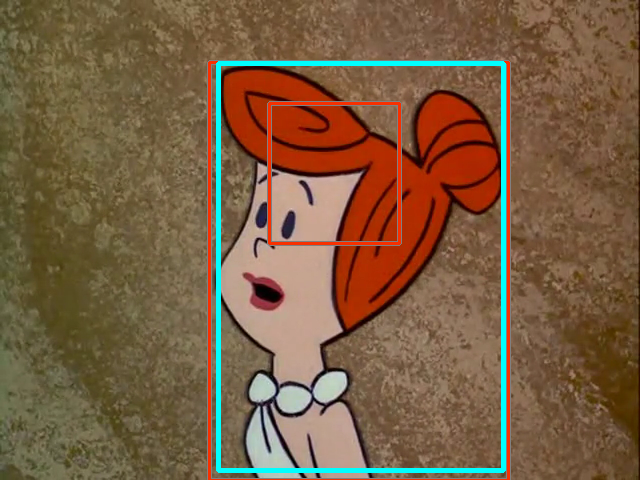

In [180]:
# aid = random.choice(filtered_out_single_vote)
aid = 's_06_e_14_shot_007535_007609'

filtered_out_anno = annotations_by_frame[aid]

review_single = {}

single_frame_image, consensus_boxes, labels = draw_image_and_labels(filtered_out_anno, cluster_from_nms)
img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
single_frame_image.save(img_path)
label_choices = select_labels(consensus_boxes, labels)
avg_votes = np.mean([box['votes'] for box in consensus_boxes])
avg_votes = np.nan_to_num(avg_votes)
possible_labels = [c['possible_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
chosen_labels = [c['chosen_labels'] for c in sorted(label_choices, key=lambda x: x['box'][0])]
review_single[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}
rev_page = generate_review_page(review_single, 'dummy.html')
print([[box['label'] for box in json.loads(anno['characterBoxes'])] for anno in filtered_out_anno])

HTML(rev_page.replace('review_frames/', 'review_results/review_frames/'))
single_frame_image

# bonus cost estimate

In [124]:
main_characters = [
    "Fred",
    "Wilma",
    "Mr Slate",
    "Barney",
    "Betty",
    "Pebbles",
    "Dino",
    "Baby Puss",
    "Hoppy",
    "Bamm Bamm",
]

empty_characters = ['no characters', 'empty frame']
main_characters += empty_characters
main_characters = [char.lower() for char in main_characters]

In [183]:
frame_cost = 0
bonus_cost = 0
for anno in list(review_seq.values()):
    frame_cost += 0.05 * 3
#     print(anno)
    bonus_cost += len([char for char in anno['chosen_labels'] if char not in main_characters]) * 0.03

In [184]:
print(frame_cost, bonus_cost)
frame_cost + bonus_cost

80.25000000000018 3.659999999999995


83.91000000000018

In [200]:
frame_count = []
for anno in list(review_seq.values()):
    frame_count += len([char for char in anno['chosen_labels'] if char not in empty_characters])

In [201]:
frame_count

787

# HTML Review

In [109]:
review_page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h3>score: {{clip[2]}}      rank: {{clip[3]}}</h3>
        <p>{{clip[1]}}</p>
        <p>{{clip[4]}}</p>
        <p>{{clip[5]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

review_single_frame_page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <p>{{clip[1]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

review_subtask_comp = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h4>original 3 frames:</h4>
        <p>{{clip[1]}}</p>
        <h4>new frames + original middle:</h4>
        <p>{{clip[2]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

In [110]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'


def make_uri(clip_id, s3_base='review_frames/', file_ext='_rev.png'):
    s3_uri = s3_base + clip_id + file_ext
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag

def make_comp_uri(clip_id, s3_base=s3_base_path):
    s3_uri = s3_base + clip_id
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag


def generate_review_page(review_seq, out_page='bbox_review.html'):
    images_sorted_by_conf = [make_uri(img[0]) for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    sorted_clip_ids = [img[0] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    votes = [img[1]['votes'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    chosen_labels = [img[1]['chosen_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    possible_labels = [img[1]['possible_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    
    send_to_template = zip(sorted_clip_ids, images_sorted_by_conf, votes, range(1, len(votes) + 1)[::-1], chosen_labels, possible_labels)
    env = Environment()
    template =  j2env.from_string(review_page_html)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = send_to_template)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
    return page_html

def generate_single_image_review_page(rev_seq, out_page='bbox_review.html'):
    images_sorted_by_conf = [make_uri(img) for img in rev_seq]
    send_to_template = zip(rev_seq, images_sorted_by_conf)
    env = Environment()
    template =  j2env.from_string(review_single_frame_page_html)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = send_to_template)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
    return page_html

def generate_subtask_review(rev_seq, out_page='review_subtask_comp.html'):
    env = Environment()
    rev_seq = [(rev[0], make_comp_uri(rev[1]), make_comp_uri(rev[2])) for rev in rev_seq]
    template =  j2env.from_string(review_subtask_comp)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = rev_seq)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
        
    return page_html

In [111]:
# page_html = generate_subtask_review(subtask_rev_seq)

# hide

In [836]:
# THREE FRAME REVIEW



# review_seq = {}
# error_frames = []
# for aid, animation_annos in tqdm(list(annotations_by_frame.items())[:5]):
#     try:
#         three_frame_img, consensus_boxes, labels = draw_animation_seq(animation_annos, cluster_from_nms)
#         avg_votes = np.mean([box['votes'] for frame in consensus_boxes for box in frame])
#         possible_labels = [c['possible_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
#         chosen_labels = [c['chosen_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
#         review_seq[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}
#         img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
#         three_frame_img.save(img_path)
#     except:
#         error_frames.append(aid)

# rev_page = generate_review_page('bbox_review_new_8_11_small.html')


In [ ]:
vote_series = pd.Series([vote for vote in review_seq.values()])

In [13]:
# assignments =[]
# for assignment_triple in list(results.values()):
#     assignments.extend(assignment_triple)

# assignment_results = [create_result(ar) for ar in assignments]

# characters_present = [{'h_id': anno['h_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

# main_characters =  {"fred",
#              "barney",
#               "wilma",
#               "betty",
#               "pebbles",
#               "bamm bamm",
#               "dino",
#               "mr slate",
#               "baby puss",
#               "hoppy",
#               "no characters"}

# def all_main(char_set, main_chars=main_characters):
#     return not bool(char_set.difference(main_chars))

# char_df = pd.DataFrame(characters_present)

# char_df['all_main'] = char_df['characters'].apply(lambda x: all_main(x))

# all_chars = [c for char_list in char_df['characters'].apply(lambda x: list(x)).tolist() for c in char_list]
# char_counts = pd.Series(all_chars).value_counts()

# # char_counts.hist(bins = 30, log=True)

# char_df['n_chars'] = char_df['characters'].apply(lambda x: len(x))

# prolific_workers = char_df['w_id'].value_counts().index.tolist()[:5]

# grouped_by_still = char_df.groupby('still_id')

# agg_df = grouped_by_still.aggregate(len)

# import scipy

# agged_on_mode = grouped_by_still.agg(lambda x: scipy.stats.mode(x))
# consensus_results_df = agged_on_mode.reset_index()

# consensus_results_df['count_mode'] = consensus_results_df['n_chars'].apply(lambda x: x[1][0])

# consensus_results_df

# consensus_results_df['mode_count'] = consensus_results_df['characters'].apply(lambda x: x[1][0])

# consensus_results_df['all_agree'] = consensus_results_df['count_mode'] == 3
# consensus_results_df['two_agree'] = consensus_results_df['count_mode'] == 2

In [87]:
# all_main_annotations_by_frame = {}
# no_main_annotations_by_frame = {}
# mixed_all_frames = {}


# for aid, annos in annotations_by_frame.items():
#     still_ids = [still['stillID'] for still in annos]
#     annos = [anno for anno in annos]
#     if len([sid for sid in still_ids if sid in all_agree_set]) == 9:
#         all_main_annotations_by_frame[aid] = annos
#     elif len([sid for sid in still_ids if sid in not_main]) == 9:
#         no_main_annotations_by_frame[aid] = annos
#     else: 
#         mixed_all_frames[aid] = annos

# print(len(all_main_annotations_by_frame), len(no_main_annotations_by_frame), len(mixed_all_frames))

In [ ]:
# char_count_df = consensus_results_df[consensus_results_df['count_mode'] == 3]

# # consensus_results_df[agree_all_main]['characters'].apply(lambda x: x[1][0]).value_counts()

# not_main =set(consensus_results_df[~agree_all_main]['still_id'].tolist())

# not_main_df = char_df[char_df['still_id'].isin(not_main)]

# consensus_results_df.head(1)

# agree_all_main = consensus_results_df['all_main'].apply(lambda x: x[1][0]) == 3 

# all_agree = consensus_results_df[agree_all_main][consensus_results_df[agree_all_main]['all_agree']]
# disagree = consensus_results_df[agree_all_main][~consensus_results_df[agree_all_main]['all_agree']]







# all_agree_set = set(all_agree['still_id'].tolist())

# count_all_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 3]['still_id'].tolist())
# count_two_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 2]['still_id'].tolist())
# count_none_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 1]['still_id'].tolist())

# conflict_images = set(disagree['still_id'].tolist())

# conflict_df = char_df[char_df['still_id'].isin(conflict_images)]

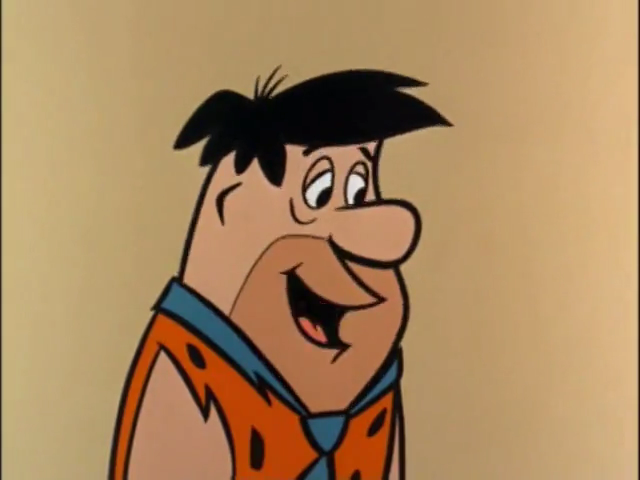

In [465]:
import PIL.Image as Image
import requests

image_n = 10


s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

image_url = s3_base_path + 's_01_e_04_shot_012010_012084_70.png'
Image.open(requests.get(image_url, stream=True).raw)